# Loading dataset

In [33]:
import warnings
warnings.filterwarnings("ignore")

from sklearn import preprocessing, metrics
from sklearn.utils import shuffle
from copy import deepcopy
import numpy as np
from numpy import newaxis
import struct
import matplotlib.pyplot as plt
import pickle
import time
import json
import codecs
from tqdm import tqdm
import pandas as pd
import cv2
#os.cpu_count() 來獲取當前機器的 CPU 核心數量
from multiprocessing import Pool, cpu_count
from skimage.feature import hog
from skimage import data

np.random.seed(0)

class NumpyJSONEncoder(json.JSONEncoder):

    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)


def save_numpy(file, x):
    with open(file, 'w') as f:
        json.dump(x, f, cls=NumpyJSONEncoder)


def print_numpy_unscientific(x):
    with np.printoptions(suppress=True):
        print(x)


def show_image(X, y):
    print("真實類別",y)
    plt.imshow(X, cmap='gray' if X.shape[2] == 1 else None)


def one_hot(y, n_values):
    return np.eye(n_values)[y.flatten()]


def reverse_one_hot(y):
    return np.argmax(y, axis=-1)

def load_image2np(img_path:str):
    global IMG_WIDTH, IMG_HEIGHT, IMG_CHA
    img_path = f"../Assignment 1-Image Classification/{img_path}"
    img = cv2.imread(img_path)
    img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    img = np.expand_dims(img, axis=0)
    return img

def load_data(meta_path:str):
    # with multiprocessing to speed up loading img
    global CPU_USED
    with open(meta_path, 'r') as f:
        data_path = [line.strip().split(' ') for line in f.readlines()]
        X, y = zip(*data_path)
        
        pool = Pool(CPU_USED)
        pool_outputs = list(tqdm(pool.imap(load_image2np, X), total=len(X)))
        X = np.concatenate(pool_outputs, axis=0)
        y = [int(i) for i in y]
        y = np.array(y)
        return X, y
        # 50s

def union_shuffle(X, y):
    global RS
    index = np.arange(X.shape[0])
    # np shuffle is inplace edit
    RS.shuffle(index)
    return X[index], y[index]


In [34]:
IMG_WIDTH = 32
IMG_HEIGHT = 32
IMG_CHA = 3
CPU_USED = 4
RANDOM_STATE = 11
RS = np.random.RandomState(RANDOM_STATE)

In [35]:
cpu_count()

16

In [36]:
train_X, train_y = load_data('../Assignment 1-Image Classification/train.txt')
val_X, val_y = load_data('../Assignment 1-Image Classification/val.txt')
test_X, test_y = load_data('../Assignment 1-Image Classification/test.txt')

100%|██████████| 450/450 [00:00<00:00, 3691.93it/s]


In [18]:
# 將像素值標準化為0到1之間
train_X = train_X/255
val_X = val_X/255
test_X = test_X/255

In [19]:
train_y = one_hot(train_y, 50)
val_y = one_hot(val_y, 50)
test_y = one_hot(test_y, 50)

train_y.shape

(63325, 50)

# Implementation

In [20]:
class Layer:
    cache_X = None
    learn_rate = 0.001

    def forward(self, X):
        self.cache_X = X.copy()

    def backward(self, grad_in):
        raise NotImplementedError


def generate_regions(X, dim, stride):
    assert X.shape[1] >= dim
    assert X.shape[2] >= dim
    # X is of shape (batch_size, height, width, in_nchannel)
    for fh, h in enumerate(range(0, X.shape[1] - dim + 1, stride)):
        for fw, w in enumerate(range(0, X.shape[2] - dim + 1, stride)):
            yield fh, fw, np.s_[:, h:h + dim, w:w + dim, :]


class Conv2D(Layer):
    W = None
    b = None
    out_nchannel = 0
    dim = 0
    stride = 0
    pad = 0

    def __init__(self, out_nchannel, dim, stride, pad):
        self.out_nchannel = out_nchannel
        self.dim = dim
        self.stride = stride
        self.pad = pad
        self.b = np.zeros(self.out_nchannel)

    def forward(self, X):
        # X is of shape (batch_size, height, width, in_nchannel)
        super().forward(X)
        out_nchannel, dim, stride, pad = self.out_nchannel, self.dim, self.stride, self.pad
        if self.W is None:
            self.W = np.random.randn(
                dim, dim, X.shape[-1], out_nchannel) * np.sqrt(
                    2 / (X.shape[1] * X.shape[2] * X.shape[3]))
        W, b = self.W, self.b

        X = np.pad(X, ((0, ), (pad, ), (pad, ), (0, )))
        WX = np.zeros((len(X), (X.shape[1] - W.shape[0]) // stride + 1,
                       (X.shape[2] - W.shape[1]) // stride + 1, out_nchannel))

        for fh, fw, slice in generate_regions(X, dim, stride):
            WX[:, fh, fw, :] = np.tensordot(X[slice], W, axes=3)
        return WX + b

    def backward(self, grad_in):
        X = self.cache_X
        dX = np.zeros_like(X, dtype=float)
        dW = np.zeros_like(self.W)
        db = np.zeros_like(self.b)
        dim, stride, pad = self.dim, self.stride, self.pad
        X = np.pad(X, ((0, ), (pad, ), (pad, ), (0, )))
        dX_pad = np.zeros_like(X, dtype=float)

        for fh, fw, slice in generate_regions(X, dim, stride):
            grad_in_slice = grad_in[:, fh, fw, newaxis, newaxis, newaxis, :]
            dX_pad[slice] += np.sum(self.W * grad_in_slice, axis=-1)
            dW += np.sum(X[slice][..., newaxis] * grad_in_slice, axis=0)
            db += np.sum(grad_in_slice, axis=0).squeeze()
        dX = dX_pad[:, pad:-pad, pad:-pad, :] if pad > 0 else dX_pad
        # assert dW.shape == self.W.shape, dW.shape
        # assert db.shape == self.b.shape, db.shape
        self.W -= dW * self.learn_rate
        self.b -= db * self.learn_rate
        # print('dW mean=', np.mean(dW), '\ndb mean=', np.mean(db))
        return dX

class SigmoidX(Layer):
    def __init__(self):
        self.X = None
        self.z = None
    
    def sigmoid(self, X):
        super().forward(X)
        return 1 / (1 + np.exp(-X))
    
    def forward(self, X):
        self.X = X
        self.z = self.sigmoid(X)
        return self.X * self.z
    
    def backward(self, grad_in):
        sig = self.sigmoid(self.X)
        dsig = sig * (1 - sig)
        dX = grad_in * sig * (self.X - self.X * sig + 1)
        return dX

class ReLU(Layer):
    def forward(self, X):
        #繼承父類（Layer中的forward）的forward方法
        super().forward(X)
        return np.maximum(X, 0)

    def backward(self, grad_in):
        dX = grad_in.copy()
        dX[self.cache_X <= 0] = 0
        return dX


class MaxPool2D(Layer):
    dim = 0
    stride = 0

    def __init__(self, dim, stride):
        self.dim = dim
        self.stride = stride

    def forward(self, X):
        # X is of shape (batch_size, height, width, in_nchannel)
        super().forward(X)
        dim, stride = self.dim, self.stride
        out_shape = ((X.shape[1] - dim) // stride + 1,
                     (X.shape[2] - dim) // stride + 1, X.shape[3])
        y = np.zeros((len(X), ) + out_shape)
        for fh, fw, slice in generate_regions(X, dim, stride):
            y[:, fh, fw, :] = np.max(X[slice], axis=(1, 2))
        return y

    def backward(self, grad_in):
        X = self.cache_X
        dim, stride = self.dim, self.stride
        dX = np.zeros_like(X, dtype=float)
        for fh, fw, slice in generate_regions(X, dim, stride):
            ## In case of multiple maximum, I first tried propagating to every max, which resulted in exploding / vanishing gradient in CIFAR-10
            ## This problem took me 2 days to debug :)
            xs = X[slice]
            indices = np.indices((xs.shape[0], xs.shape[-1]))
            max_indices = (indices[0], ) + np.unravel_index(
                xs.reshape((xs.shape[0], -1, xs.shape[-1])).argmax(axis=1),
                xs.shape[1:-1]) + (indices[1], )
            mask = np.zeros_like(xs)
            mask[max_indices] = 1
            dX[slice] += mask * grad_in[:, fh, newaxis, fw, newaxis, :]
        return dX


class Flatten(Layer):

    def forward(self, X):
        # X is of shape (batch_size, height, width, in_nchannel)
        # output is of shape (batch_size, -1)
        super().forward(X)
        return X.reshape((len(X), -1))

    def backward(self, grad_in):
        return grad_in.reshape(self.cache_X.shape)


class Dense(Layer):
    W = None
    b = None
    out_dim = 0

    def __init__(self, out_dim):
        self.out_dim = out_dim
        self.b = np.zeros(out_dim)

    def forward(self, X):
        # X is of shape (batch_size, in_dim)
        # output is of shape (batch_size, out_dim)
        super().forward(X)
        in_dim = X.shape[-1]
        if self.W is None:
            self.W = np.random.randn(in_dim, self.out_dim) * np.sqrt(
                2 / in_dim)
        return X @ self.W + self.b

    def backward(self, grad_in):
        X = self.cache_X
        dX = grad_in @ self.W.T
        dW = X.T @ grad_in
        db = np.sum(grad_in, axis=0)
        # assert dW.shape == self.W.shape, dW.shape
        # assert db.shape == self.b.shape, db.shape
        self.W -= dW * self.learn_rate
        self.b -= db * self.learn_rate
        # print('dW mean=', np.mean(dW), '\ndb mean=', np.mean(db))
        return dX


def softmax(X, axis=-1, epsilon=1e-9):
    # actual softmax function is np.exp(X)/np.exp(X).sum(), here same value is calculated in a different way
    e_x = np.exp(X - np.max(X, axis=axis, keepdims=True))
    probs = e_x / e_x.sum(axis=axis, keepdims=True)
    # return preprocessing.normalize(probs + epsilon, norm='l1')
    return probs


class SoftmaxCrossEntropy(Layer):
    cache_grad = None

    def forward(self, X, y):
        # X, y and y_hat are of shape (batch_size, in_dim)
        super().forward(X)
        m = len(X)
        y_hat = softmax(X)
        loss = (-1 / m) * np.log(y_hat[y == 1]).sum()
        self.cache_grad = (y_hat - y) / m
        return y_hat, loss

    def backward(self, grad_in):
        return self.cache_grad

In [21]:
class Model:
    layers = []
    learn_rate = 0

    def __init__(self, layers, learn_rate=0.001):
        for layer in layers:
            layer.learn_rate = learn_rate
        self.layers = layers
        self.learn_rate = learn_rate
        self.loss_t = []
        self.loss_v = []
        self.acc_t = []
        self.acc_v = []
    def forward(self, X, y=None):
        m = len(X)
        for layer in self.layers[:-1]:
            X = layer.forward(X)
        if y is None:
            return softmax(X)
        assert len(y) == m
        y_hat, loss = self.layers[-1].forward(X, y)
        return y_hat, loss

    def backward(self):
        grad = 1
        for layer in reversed(self.layers):
            grad = layer.backward(grad)
        return grad

    def fit(self,
            X_train,
            y_train,
            X_validate,
            y_validate,
            epochs=1,
            batch_size=32):
        print('batch_size',batch_size)
        n_sample = len(X_train)
        n_batch = (n_sample - 1) // batch_size + 1
        y_pred = np.zeros_like(y_train)
        loss_t = []
        loss_v = []
        acc_t = []
        acc_v = []
        for epoch in range(epochs):
            print("="*25)
            print(f"Epoch {epoch+1}")
            with tqdm(total=n_batch) as t:
                tot_loss = tot_acc = 0
                for i in range(n_batch):
                    batch = range(batch_size * i,
                                  min(batch_size * (i + 1), n_sample))
                    y_hat, loss = self.forward(X_train[batch], y_train[batch])
                    acc = (1 / len(batch)) * np.sum(
                        reverse_one_hot(y_hat) == reverse_one_hot(
                            y_train[batch]))
                    y_pred[batch] = y_hat

                    grad = self.backward()

                    tot_loss += loss
                    tot_acc += acc
                    if (i + 1) % batch_size == 0 or i + 1 == n_batch:
                        loss_t.append(tot_loss / (i + 1))
                        acc_t.append(tot_acc / (i + 1))
                        t.set_postfix({
                            'avg_loss': tot_loss / (i + 1),
                            'avg_accuracy': tot_acc / (i + 1),
                            'max_abs_gradient': np.max(abs(grad))
                        })
                        cur_n_batch = i % batch_size + 1
                        t.update(cur_n_batch)
            print("Validation:")
            val_y_hat, val_loss = self.evaluate(X_validate, y_validate,batch_size)
            acc_val =  round(np.sum(reverse_one_hot(val_y_hat) == reverse_one_hot(y_validate)) / len(val_y_hat),3)
            
            loss_v.append(val_loss)
            acc_v.append(acc_val)
            print('loss: ', val_loss,'acc',acc_val)
#             print(
#                 metrics.classification_report(reverse_one_hot(val_y_hat),
#                                               reverse_one_hot(y_validate)))
        self.loss_t = loss_t
        self.loss_v = loss_v
        self.acc_t = acc_t
        self.acc_v = acc_v
    def predict(self, X, batch_size=32):
        y_pred = []
        n_sample = len(X)
        n_batch = (n_sample - 1) // batch_size + 1
        for i in tqdm(range(n_batch)):
            batch = range(batch_size * i, min(batch_size * (i + 1), n_sample))
            y_hat = self.forward(X[batch])
            y_pred.append(y_hat)
        return np.concatenate(y_pred)

    def evaluate(self, X, y, batch_size=32):
        print('batch_size',batch_size)
        y_pred = []
        n_sample = len(X)
        n_batch = (n_sample - 1) // batch_size + 1
        tot_loss = 0
        for i in range(n_batch):
            batch = range(batch_size * i, min(batch_size * (i + 1), n_sample))
            y_hat, loss = self.forward(X[batch], y[batch])
            y_pred.append(y_hat)
            tot_loss += loss
        
        return np.concatenate(y_pred), tot_loss / n_batch

    def get_weights(self):
        weights = []
        for layer in self.layers:
            if hasattr(layer, 'W'):
                weights.append(layer.W)
            if hasattr(layer, 'b'):
                weights.append(layer.b)
        return weights

    def set_weights(self, weights):
        # careful of not copying by reference
        weight_iter = iter(weights)
        for layer in self.layers:
            if hasattr(layer, 'W'):
                layer.W = np.array(next(weight_iter))
            if hasattr(layer, 'b'):
                layer.b = np.array(next(weight_iter))


## shuffle

In [22]:
import random
random.seed(2023)
a = list(range(len(train_X)))
random.shuffle(a)

train_xr = train_X[a]
train_yr = train_y[a]

Epochs = 25

## <font color=red size=6 > single one-layer perceptron <font>
# Create model

In [89]:
np.random.seed(0)   ## to get deterministic weights

model_one_nn = Model([
    Flatten(),
    Dense(50),
    SoftmaxCrossEntropy()
],
    learn_rate=0.02)


# Training

In [90]:
model_one_nn.fit(train_xr, train_yr, val_X, val_y, epochs=Epochs, batch_size=32)


batch_size 32
Epoch 1


100%|██████████| 1979/1979 [00:01<00:00, 1913.09it/s, avg_loss=3.75, avg_accuracy=0.0654, max_abs_gradient=0.00394]


Validation:
batch_size 32
loss:  3.59361199900336 acc 0.082
Epoch 2


100%|██████████| 1979/1979 [00:01<00:00, 1913.14it/s, avg_loss=3.62, avg_accuracy=0.0881, max_abs_gradient=0.00379]


Validation:
batch_size 32
loss:  3.542580754678069 acc 0.098
Epoch 3


100%|██████████| 1979/1979 [00:01<00:00, 1927.28it/s, avg_loss=3.56, avg_accuracy=0.1, max_abs_gradient=0.00391]  


Validation:
batch_size 32
loss:  3.5190529507281973 acc 0.102
Epoch 4


100%|██████████| 1979/1979 [00:01<00:00, 1873.21it/s, avg_loss=3.52, avg_accuracy=0.108, max_abs_gradient=0.0042] 


Validation:
batch_size 32
loss:  3.5061677553312784 acc 0.102
Epoch 5


100%|██████████| 1979/1979 [00:01<00:00, 1921.40it/s, avg_loss=3.48, avg_accuracy=0.115, max_abs_gradient=0.00445]


Validation:
batch_size 32
loss:  3.4987524342133884 acc 0.102
Epoch 6


100%|██████████| 1979/1979 [00:01<00:00, 1869.68it/s, avg_loss=3.46, avg_accuracy=0.122, max_abs_gradient=0.00467]


Validation:
batch_size 32
loss:  3.4946053061620033 acc 0.109
Epoch 7


100%|██████████| 1979/1979 [00:01<00:00, 1849.55it/s, avg_loss=3.43, avg_accuracy=0.127, max_abs_gradient=0.00487]


Validation:
batch_size 32
loss:  3.4925999270426127 acc 0.109
Epoch 8


100%|██████████| 1979/1979 [00:01<00:00, 1887.94it/s, avg_loss=3.41, avg_accuracy=0.132, max_abs_gradient=0.00506]


Validation:
batch_size 32
loss:  3.492085448178697 acc 0.111
Epoch 9


100%|██████████| 1979/1979 [00:01<00:00, 1855.73it/s, avg_loss=3.39, avg_accuracy=0.137, max_abs_gradient=0.00523]


Validation:
batch_size 32
loss:  3.4926542070491755 acc 0.104
Epoch 10


100%|██████████| 1979/1979 [00:01<00:00, 1893.54it/s, avg_loss=3.37, avg_accuracy=0.14, max_abs_gradient=0.00539] 


Validation:
batch_size 32
loss:  3.494035977689013 acc 0.1
Epoch 11


100%|██████████| 1979/1979 [00:01<00:00, 1824.73it/s, avg_loss=3.36, avg_accuracy=0.144, max_abs_gradient=0.00575]


Validation:
batch_size 32
loss:  3.496043652352176 acc 0.107
Epoch 12


100%|██████████| 1979/1979 [00:01<00:00, 1869.62it/s, avg_loss=3.34, avg_accuracy=0.147, max_abs_gradient=0.0061] 


Validation:
batch_size 32
loss:  3.4985429290238304 acc 0.107
Epoch 13


100%|██████████| 1979/1979 [00:01<00:00, 1910.40it/s, avg_loss=3.33, avg_accuracy=0.15, max_abs_gradient=0.00643] 


Validation:
batch_size 32
loss:  3.5014343863748385 acc 0.109
Epoch 14


100%|██████████| 1979/1979 [00:01<00:00, 1817.27it/s, avg_loss=3.32, avg_accuracy=0.154, max_abs_gradient=0.00674]


Validation:
batch_size 32
loss:  3.5046424144958244 acc 0.107
Epoch 15


100%|██████████| 1979/1979 [00:01<00:00, 1853.97it/s, avg_loss=3.3, avg_accuracy=0.157, max_abs_gradient=0.00704] 


Validation:
batch_size 32
loss:  3.508108138984382 acc 0.104
Epoch 16


100%|██████████| 1979/1979 [00:01<00:00, 1883.29it/s, avg_loss=3.29, avg_accuracy=0.159, max_abs_gradient=0.00732]


Validation:
batch_size 32
loss:  3.5117847639645183 acc 0.104
Epoch 17


100%|██████████| 1979/1979 [00:01<00:00, 1910.58it/s, avg_loss=3.28, avg_accuracy=0.162, max_abs_gradient=0.0076] 


Validation:
batch_size 32
loss:  3.515634427063686 acc 0.104
Epoch 18


100%|██████████| 1979/1979 [00:01<00:00, 1883.74it/s, avg_loss=3.27, avg_accuracy=0.164, max_abs_gradient=0.00786]


Validation:
batch_size 32
loss:  3.5196260246754463 acc 0.104
Epoch 19


100%|██████████| 1979/1979 [00:01<00:00, 1857.07it/s, avg_loss=3.26, avg_accuracy=0.166, max_abs_gradient=0.00812]


Validation:
batch_size 32
loss:  3.52373367445185 acc 0.107
Epoch 20


100%|██████████| 1979/1979 [00:01<00:00, 1855.02it/s, avg_loss=3.25, avg_accuracy=0.169, max_abs_gradient=0.00836]


Validation:
batch_size 32
loss:  3.5279356051779076 acc 0.107
Epoch 21


100%|██████████| 1979/1979 [00:01<00:00, 1869.71it/s, avg_loss=3.25, avg_accuracy=0.171, max_abs_gradient=0.0086] 


Validation:
batch_size 32
loss:  3.532213338961052 acc 0.104
Epoch 22


100%|██████████| 1979/1979 [00:01<00:00, 1872.02it/s, avg_loss=3.24, avg_accuracy=0.173, max_abs_gradient=0.00882]


Validation:
batch_size 32
loss:  3.536551077109892 acc 0.104
Epoch 23


100%|██████████| 1979/1979 [00:01<00:00, 1882.58it/s, avg_loss=3.23, avg_accuracy=0.175, max_abs_gradient=0.00904]


Validation:
batch_size 32
loss:  3.540935230502232 acc 0.104
Epoch 24


100%|██████████| 1979/1979 [00:01<00:00, 1888.29it/s, avg_loss=3.22, avg_accuracy=0.177, max_abs_gradient=0.00926]


Validation:
batch_size 32
loss:  3.545354054227773 acc 0.104
Epoch 25


100%|██████████| 1979/1979 [00:01<00:00, 1877.31it/s, avg_loss=3.21, avg_accuracy=0.178, max_abs_gradient=0.00946]

Validation:
batch_size 32
loss:  3.549797358748094 acc 0.104


In [91]:
### Saving trained weights
save_numpy('weights_one_nn.txt', model_one_nn.get_weights())
### Loading trained weights
with open('weights_one_nn.txt', 'r') as f:
    weights = json.load(f)
    model_one_nn.set_weights(weights)

# Testing

In [92]:
y_pred, test_loss = model_one_nn.evaluate(test_X, test_y)
# print('Test\nloss: ', test_loss)
# support指有多少樣本數預測成此類別
print(
    metrics.classification_report(reverse_one_hot(y_pred),
                                  reverse_one_hot(test_y)))

batch_size 32
              precision    recall  f1-score   support

           0       0.44      0.33      0.38        12
           1       0.11      0.09      0.10        11
           2       0.00      0.00      0.00         2
           3       0.11      0.06      0.08        16
           4       0.22      0.67      0.33         3
           5       0.00      0.00      0.00         2
           6       0.22      0.12      0.15        17
           7       0.00      0.00      0.00         4
           8       0.11      0.09      0.10        11
           9       0.00      0.00      0.00         7
          10       0.00      0.00      0.00        11
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00         4
          13       0.00      0.00      0.00         2
          14       0.00      0.00      0.00         8
          15       0.11      0.08      0.10        12
          16       0.00      0.00      0.00         4
          17 

## <font color=red size=6 > two-layer perceptron <font>
# Create model

In [93]:
np.random.seed(0)   ## to get deterministic weights

model_two_nn = Model([
    Flatten(),
    Dense(84),
    Dense(50),
    SoftmaxCrossEntropy()
],
    learn_rate=0.02)


# Training

In [94]:
model_two_nn.fit(train_xr, train_yr, val_X, val_y, epochs=Epochs, batch_size=32)


batch_size 32
Epoch 1


100%|██████████| 1979/1979 [00:01<00:00, 1262.04it/s, avg_loss=3.88, avg_accuracy=0.0622, max_abs_gradient=0.00453]


Validation:
batch_size 32
loss:  3.601305661181089 acc 0.091
Epoch 2


100%|██████████| 1979/1979 [00:01<00:00, 1249.78it/s, avg_loss=3.58, avg_accuracy=0.0947, max_abs_gradient=0.0046] 


Validation:
batch_size 32
loss:  3.489456290609793 acc 0.102
Epoch 3


100%|██████████| 1979/1979 [00:01<00:00, 1196.03it/s, avg_loss=3.5, avg_accuracy=0.109, max_abs_gradient=0.00523] 


Validation:
batch_size 32
loss:  3.452079884977192 acc 0.113
Epoch 4


100%|██████████| 1979/1979 [00:01<00:00, 1171.12it/s, avg_loss=3.46, avg_accuracy=0.119, max_abs_gradient=0.00573]


Validation:
batch_size 32
loss:  3.432579760813614 acc 0.116
Epoch 5


100%|██████████| 1979/1979 [00:01<00:00, 1172.11it/s, avg_loss=3.43, avg_accuracy=0.126, max_abs_gradient=0.00614]


Validation:
batch_size 32
loss:  3.4218250838901345 acc 0.118
Epoch 6


100%|██████████| 1979/1979 [00:01<00:00, 1171.40it/s, avg_loss=3.41, avg_accuracy=0.131, max_abs_gradient=0.00649]


Validation:
batch_size 32
loss:  3.415787957156493 acc 0.122
Epoch 7


100%|██████████| 1979/1979 [00:01<00:00, 1173.01it/s, avg_loss=3.4, avg_accuracy=0.135, max_abs_gradient=0.00681]


Validation:
batch_size 32
loss:  3.412421401252511 acc 0.122
Epoch 8


100%|██████████| 1979/1979 [00:01<00:00, 1172.53it/s, avg_loss=3.38, avg_accuracy=0.139, max_abs_gradient=0.00713]


Validation:
batch_size 32
loss:  3.410844229483351 acc 0.127
Epoch 9


100%|██████████| 1979/1979 [00:01<00:00, 1172.52it/s, avg_loss=3.37, avg_accuracy=0.142, max_abs_gradient=0.00743]


Validation:
batch_size 32
loss:  3.4106503427348325 acc 0.129
Epoch 10


100%|██████████| 1979/1979 [00:01<00:00, 1172.50it/s, avg_loss=3.36, avg_accuracy=0.144, max_abs_gradient=0.00774]


Validation:
batch_size 32
loss:  3.4116042148207653 acc 0.127
Epoch 11


100%|██████████| 1979/1979 [00:01<00:00, 1171.09it/s, avg_loss=3.35, avg_accuracy=0.146, max_abs_gradient=0.00804]


Validation:
batch_size 32
loss:  3.4135419822703486 acc 0.122
Epoch 12


100%|██████████| 1979/1979 [00:01<00:00, 1174.08it/s, avg_loss=3.34, avg_accuracy=0.148, max_abs_gradient=0.00833]


Validation:
batch_size 32
loss:  3.416337576777662 acc 0.124
Epoch 13


100%|██████████| 1979/1979 [00:01<00:00, 1171.76it/s, avg_loss=3.33, avg_accuracy=0.151, max_abs_gradient=0.00862]


Validation:
batch_size 32
loss:  3.419887230723316 acc 0.12
Epoch 14


100%|██████████| 1979/1979 [00:01<00:00, 1171.65it/s, avg_loss=3.32, avg_accuracy=0.153, max_abs_gradient=0.0089] 


Validation:
batch_size 32
loss:  3.4241005673590257 acc 0.12
Epoch 15


100%|██████████| 1979/1979 [00:01<00:00, 1158.85it/s, avg_loss=3.31, avg_accuracy=0.155, max_abs_gradient=0.00918]


Validation:
batch_size 32
loss:  3.4288950756744887 acc 0.116
Epoch 16


100%|██████████| 1979/1979 [00:01<00:00, 1160.70it/s, avg_loss=3.31, avg_accuracy=0.157, max_abs_gradient=0.00945]


Validation:
batch_size 32
loss:  3.4341927943083146 acc 0.113
Epoch 17


100%|██████████| 1979/1979 [00:01<00:00, 1158.80it/s, avg_loss=3.3, avg_accuracy=0.159, max_abs_gradient=0.00972]


Validation:
batch_size 32
loss:  3.439918648240803 acc 0.113
Epoch 18


100%|██████████| 1979/1979 [00:01<00:00, 1156.10it/s, avg_loss=3.29, avg_accuracy=0.161, max_abs_gradient=0.00998]


Validation:
batch_size 32
loss:  3.4460000491135907 acc 0.116
Epoch 19


100%|██████████| 1979/1979 [00:01<00:00, 1158.55it/s, avg_loss=3.28, avg_accuracy=0.162, max_abs_gradient=0.0102] 


Validation:
batch_size 32
loss:  3.452367355537192 acc 0.118
Epoch 20


100%|██████████| 1979/1979 [00:01<00:00, 1158.76it/s, avg_loss=3.28, avg_accuracy=0.164, max_abs_gradient=0.0105] 


Validation:
batch_size 32
loss:  3.45895477218601 acc 0.116
Epoch 21


100%|██████████| 1979/1979 [00:01<00:00, 1253.59it/s, avg_loss=3.27, avg_accuracy=0.165, max_abs_gradient=0.0107] 


Validation:
batch_size 32
loss:  3.465701323463546 acc 0.113
Epoch 22


100%|██████████| 1979/1979 [00:01<00:00, 1264.56it/s, avg_loss=3.26, avg_accuracy=0.167, max_abs_gradient=0.011]  


Validation:
batch_size 32
loss:  3.4725516543503034 acc 0.113
Epoch 23


100%|██████████| 1979/1979 [00:01<00:00, 1274.69it/s, avg_loss=3.26, avg_accuracy=0.168, max_abs_gradient=0.0112] 


Validation:
batch_size 32
loss:  3.479456538756324 acc 0.116
Epoch 24


100%|██████████| 1979/1979 [00:01<00:00, 1254.39it/s, avg_loss=3.25, avg_accuracy=0.169, max_abs_gradient=0.0114] 


Validation:
batch_size 32
loss:  3.486373076628843 acc 0.113
Epoch 25


100%|██████████| 1979/1979 [00:01<00:00, 1166.89it/s, avg_loss=3.24, avg_accuracy=0.171, max_abs_gradient=0.0116] 

Validation:
batch_size 32
loss:  3.493264621736245 acc 0.113


In [95]:
### Saving trained weights
save_numpy('weights_two_nn.txt', model_two_nn.get_weights())
### Loading trained weights
with open('weights_two_nn.txt', 'r') as f:
    weights = json.load(f)
    model_two_nn.set_weights(weights)

# Testing

In [96]:
y_pred, test_loss = model_two_nn.evaluate(test_X, test_y)
# print('Test\nloss: ', test_loss)
# support指有多少樣本數預測成此類別
print(
    metrics.classification_report(reverse_one_hot(y_pred),
                                  reverse_one_hot(test_y)))

batch_size 32
              precision    recall  f1-score   support

           0       0.33      0.30      0.32        10
           1       0.11      0.10      0.11        10
           2       0.11      0.50      0.18         2
           3       0.00      0.00      0.00        24
           4       0.11      0.50      0.18         2
           5       0.11      0.25      0.15         4
           6       0.22      0.12      0.15        17
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00         8
           9       0.00      0.00      0.00         2
          10       0.00      0.00      0.00        13
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00         4
          13       0.00      0.00      0.00         7
          14       0.22      0.08      0.12        25
          15       0.11      0.17      0.13         6
          16       0.00      0.00      0.00         0
          17 

## <font color=red size=6 > 原本的Lenet-5 <font>
# Create model 


In [115]:
np.random.seed(0)   ## to get deterministic weights

model_Lenet5 = Model([
    Conv2D(6, 5, 1, 0),
    ReLU(),
    MaxPool2D(2, 2),
    Conv2D(16, 5, 1, 0),
    ReLU(),
    MaxPool2D(2, 2),
    Flatten(),
    Dense(120),
    Dense(84),
    Dense(50),
    SoftmaxCrossEntropy()
],
    learn_rate=0.02)


# Training

In [116]:
model_Lenet5.fit(train_xr, train_yr, val_X, val_y, epochs=Epochs, batch_size=32)

batch_size 32
Epoch 1


100%|██████████| 1979/1979 [05:55<00:00,  5.57it/s, avg_loss=3.83, avg_accuracy=0.041, max_abs_gradient=0.00406] 


Validation:
batch_size 32
loss:  3.7764471653839546 acc 0.062
Epoch 2


100%|██████████| 1979/1979 [05:59<00:00,  5.50it/s, avg_loss=3.6, avg_accuracy=0.0793, max_abs_gradient=0.00886] 


Validation:
batch_size 32
loss:  3.4801480982501753 acc 0.091
Epoch 3


100%|██████████| 1979/1979 [06:21<00:00,  5.19it/s, avg_loss=3.42, avg_accuracy=0.113, max_abs_gradient=0.0108] 


Validation:
batch_size 32
loss:  3.2962511201964833 acc 0.129
Epoch 4


100%|██████████| 1979/1979 [06:24<00:00,  5.15it/s, avg_loss=3.32, avg_accuracy=0.135, max_abs_gradient=0.014] 


Validation:
batch_size 32
loss:  3.2495842687224252 acc 0.133
Epoch 5


100%|██████████| 1979/1979 [06:22<00:00,  5.17it/s, avg_loss=3.23, avg_accuracy=0.154, max_abs_gradient=0.0226]


Validation:
batch_size 32
loss:  3.1777661365733163 acc 0.142
Epoch 6


100%|██████████| 1979/1979 [06:22<00:00,  5.17it/s, avg_loss=3.15, avg_accuracy=0.171, max_abs_gradient=0.0282]


Validation:
batch_size 32
loss:  3.1299565573468318 acc 0.144
Epoch 7


100%|██████████| 1979/1979 [06:21<00:00,  5.18it/s, avg_loss=3.09, avg_accuracy=0.183, max_abs_gradient=0.0301]


Validation:
batch_size 32
loss:  3.0917186291162886 acc 0.158
Epoch 8


100%|██████████| 1979/1979 [06:24<00:00,  5.14it/s, avg_loss=3.05, avg_accuracy=0.194, max_abs_gradient=0.0299]


Validation:
batch_size 32
loss:  3.080138738353408 acc 0.151
Epoch 9


100%|██████████| 1979/1979 [06:22<00:00,  5.17it/s, avg_loss=3.02, avg_accuracy=0.202, max_abs_gradient=0.034] 


Validation:
batch_size 32
loss:  3.0731690211062195 acc 0.151
Epoch 10


100%|██████████| 1979/1979 [06:22<00:00,  5.17it/s, avg_loss=2.99, avg_accuracy=0.207, max_abs_gradient=0.0348]


Validation:
batch_size 32
loss:  3.0744490167032077 acc 0.151
Epoch 11


100%|██████████| 1979/1979 [06:23<00:00,  5.16it/s, avg_loss=2.97, avg_accuracy=0.211, max_abs_gradient=0.0434]


Validation:
batch_size 32
loss:  3.0572084140466376 acc 0.162
Epoch 12


100%|██████████| 1979/1979 [06:19<00:00,  5.21it/s, avg_loss=2.95, avg_accuracy=0.215, max_abs_gradient=0.0519]


Validation:
batch_size 32
loss:  3.054637890233106 acc 0.164
Epoch 13


100%|██████████| 1979/1979 [06:22<00:00,  5.17it/s, avg_loss=2.94, avg_accuracy=0.219, max_abs_gradient=0.0504]


Validation:
batch_size 32
loss:  3.046719357414406 acc 0.162
Epoch 14


100%|██████████| 1979/1979 [06:22<00:00,  5.17it/s, avg_loss=2.92, avg_accuracy=0.223, max_abs_gradient=0.0531]


Validation:
batch_size 32
loss:  3.042625217113313 acc 0.169
Epoch 15


100%|██████████| 1979/1979 [06:23<00:00,  5.16it/s, avg_loss=2.9, avg_accuracy=0.226, max_abs_gradient=0.0544]


Validation:
batch_size 32
loss:  3.038832107323139 acc 0.173
Epoch 16


100%|██████████| 1979/1979 [06:20<00:00,  5.20it/s, avg_loss=2.89, avg_accuracy=0.23, max_abs_gradient=0.0569] 


Validation:
batch_size 32
loss:  3.033712953225142 acc 0.169
Epoch 17


100%|██████████| 1979/1979 [06:24<00:00,  5.14it/s, avg_loss=2.88, avg_accuracy=0.233, max_abs_gradient=0.0558]


Validation:
batch_size 32
loss:  3.0007294606247896 acc 0.176
Epoch 18


100%|██████████| 1979/1979 [06:19<00:00,  5.22it/s, avg_loss=2.87, avg_accuracy=0.235, max_abs_gradient=0.0524]


Validation:
batch_size 32
loss:  3.003711157060444 acc 0.167
Epoch 19


100%|██████████| 1979/1979 [06:23<00:00,  5.17it/s, avg_loss=2.86, avg_accuracy=0.238, max_abs_gradient=0.0553]


Validation:
batch_size 32
loss:  3.000668333391736 acc 0.167
Epoch 20


100%|██████████| 1979/1979 [06:19<00:00,  5.22it/s, avg_loss=2.85, avg_accuracy=0.239, max_abs_gradient=0.0464]


Validation:
batch_size 32
loss:  3.0012877522399473 acc 0.176
Epoch 21


100%|██████████| 1979/1979 [06:22<00:00,  5.17it/s, avg_loss=2.84, avg_accuracy=0.241, max_abs_gradient=0.0488]


Validation:
batch_size 32
loss:  3.0042824799802035 acc 0.18
Epoch 22


100%|██████████| 1979/1979 [06:24<00:00,  5.15it/s, avg_loss=2.83, avg_accuracy=0.242, max_abs_gradient=0.0506]


Validation:
batch_size 32
loss:  2.998004919232064 acc 0.173
Epoch 23


100%|██████████| 1979/1979 [06:22<00:00,  5.18it/s, avg_loss=2.82, avg_accuracy=0.243, max_abs_gradient=0.0478]


Validation:
batch_size 32
loss:  2.999674128848377 acc 0.176
Epoch 24


100%|██████████| 1979/1979 [06:21<00:00,  5.19it/s, avg_loss=2.82, avg_accuracy=0.245, max_abs_gradient=0.0508]


Validation:
batch_size 32
loss:  2.990373931556824 acc 0.187
Epoch 25


100%|██████████| 1979/1979 [06:22<00:00,  5.17it/s, avg_loss=2.81, avg_accuracy=0.246, max_abs_gradient=0.0588]


Validation:
batch_size 32
loss:  2.987208938630825 acc 0.178


In [118]:
### Saving trained weights
save_numpy('weights_Lenet51.txt', model_Lenet5.get_weights())
### Loading trained weights
with open('weights_Lenet51.txt', 'r') as f:
    weights = json.load(f)
    model_Lenet5.set_weights(weights)

# Testing

In [122]:
y_pred, test_loss = model_Lenet5.evaluate(test_X, test_y)
# print('Test\nloss: ', test_loss)
# support指有多少樣本數預測成此類別
print(
    metrics.classification_report(reverse_one_hot(y_pred),
                                  reverse_one_hot(test_y)))

batch_size 32
              precision    recall  f1-score   support

           0       0.22      0.18      0.20        11
           1       0.00      0.00      0.00         7
           2       0.11      0.17      0.13         6
           3       0.33      0.23      0.27        13
           4       0.22      0.10      0.14        20
           5       0.22      0.14      0.17        14
           6       0.11      0.11      0.11         9
           7       0.22      0.12      0.15        17
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00         0
          10       0.11      0.25      0.15         4
          11       0.11      0.12      0.12         8
          12       0.22      0.40      0.29         5
          13       0.00      0.00      0.00         8
          14       0.33      0.12      0.18        25
          15       0.00      0.00      0.00        10
          16       0.00      0.00      0.00         4
          17 

## <font color=red size=6 > 改後的Lenet-5 <font>
# Create model 
#### 1.架構多增加Conv2D(120, 3, 1, 0),SigmoidX(),MaxPool2D(2, 2),
#### 2.ReLU改成SigmoidX 
#### 3.Conv2D 5*5改成 3*3

In [23]:
np.random.seed(0)   ## to get deterministic weights

model_change_LeNet = Model([
    Conv2D(6, 3, 1, 0),
    SigmoidX(),
    MaxPool2D(2, 2),
    Conv2D(16, 3, 1, 0),
    SigmoidX(),
    MaxPool2D(2, 2),
    Conv2D(120, 3, 1, 0),
    SigmoidX(),
    MaxPool2D(2, 2),
    Flatten(),
    Dense(120),
    Dense(84),
    Dense(50),
    SoftmaxCrossEntropy()
],
    learn_rate=0.02)


# Training

In [ ]:
model_change_LeNet.fit(train_xr, train_yr, val_X, val_y, epochs=Epochs, batch_size=32)

In [108]:
### Saving trained weights
save_numpy('weights_change_LeNet.txt', model_change_LeNet.get_weights())
### Loading trained weights
with open('weights_change_LeNet.txt', 'r') as f:
    weights = json.load(f)
    model_change_LeNet.set_weights(weights)

# Testing

In [ ]:
y_pred, test_loss = model_change_LeNet.evaluate(test_X, test_y)
# print('Test\nloss: ', test_loss)
# support指有多少樣本數預測成此類別
print(
    metrics.classification_report(reverse_one_hot(y_pred),
                                  reverse_one_hot(test_y)))

真實類別  37


100%|██████████| 1/1 [00:00<00:00, 68.92it/s]

預測類別 37 機率 0.12270513009311099

 預測為各類別的機率 
 [[ 0.          0.00035605]
 [ 1.          0.0004642 ]
 [ 2.          0.00012126]
 [ 3.          0.00123583]
 [ 4.          0.00092423]
 [ 5.          0.00130257]
 [ 6.          0.0020065 ]
 [ 7.          0.00214889]
 [ 8.          0.00339595]
 [ 9.          0.00097879]
 [10.          0.0015902 ]
 [11.          0.00106971]
 [12.          0.00089912]
 [13.          0.03924968]
 [14.          0.00208666]
 [15.          0.01342062]
 [16.          0.08361578]
 [17.          0.01353453]
 [18.          0.01887162]
 [19.          0.07565841]
 [20.          0.04399608]
 [21.          0.03890459]
 [22.          0.09891671]
 [23.          0.00034296]
 [24.          0.0111774 ]
 [25.          0.01224789]
 [26.          0.04084298]
 [27.          0.00115744]
 [28.          0.00034507]
 [29.          0.01126134]
 [30.          0.01072717]
 [31.          0.05821609]
 [32.          0.08221713]
 [33.          0.00587378]
 [34.          0.07408778]
 [35.     

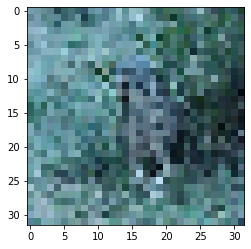

In [79]:
def print_numpy_unscientific(x):
    with np.printoptions(suppress=True):
        for i in range(0,49):
            if x[i,1:] == x[:50,1:].max():
                print('預測類別',i,'機率',x[:50,1:].max())
        print('\n 預測為各類別的機率 \n',x)
def show_image(X, y):
    print("真實類別 ",y)
    plt.imshow(X, cmap='gray' if X.shape[2] == 1 else None)
               
rand_idx = np.random.choice(len(test_X))
label = reverse_one_hot(test_y[rand_idx])
show_image(test_X[rand_idx], label)
batch = range(rand_idx, rand_idx + 1)
y_hat = model.predict(test_X[batch])
print_numpy_unscientific(np.array(list(enumerate(y_hat.squeeze()))))

# 畫Loss和Accuracy

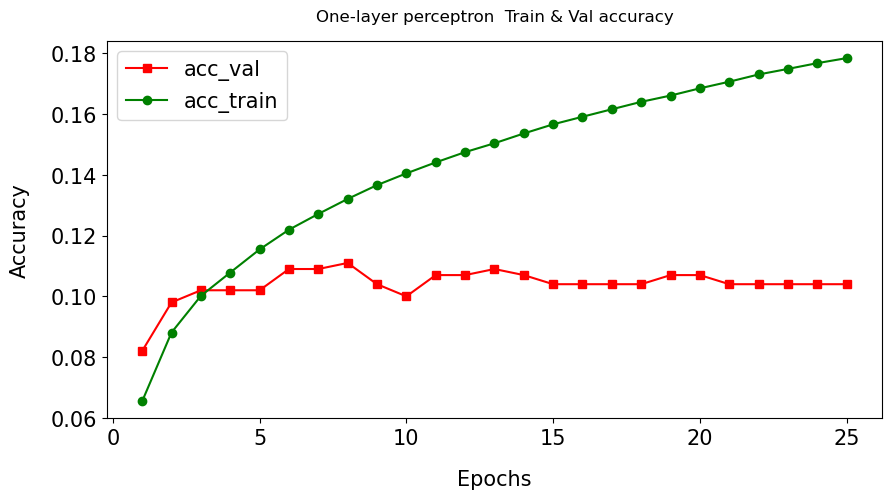

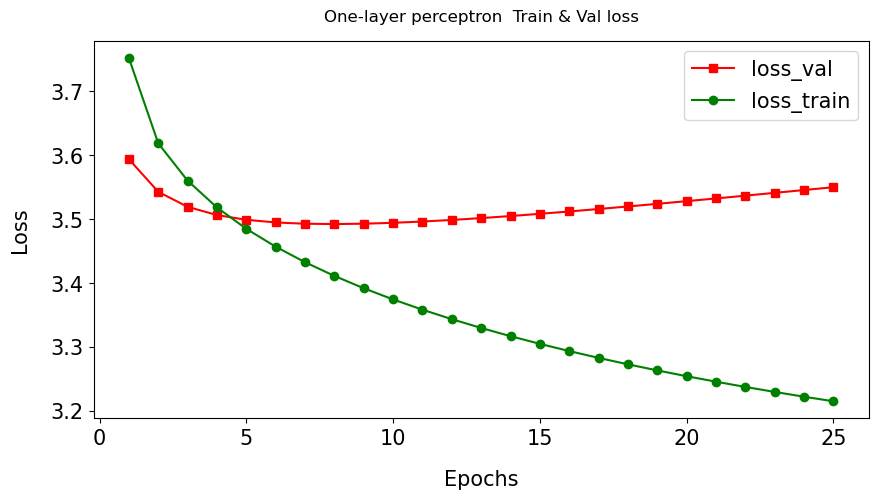

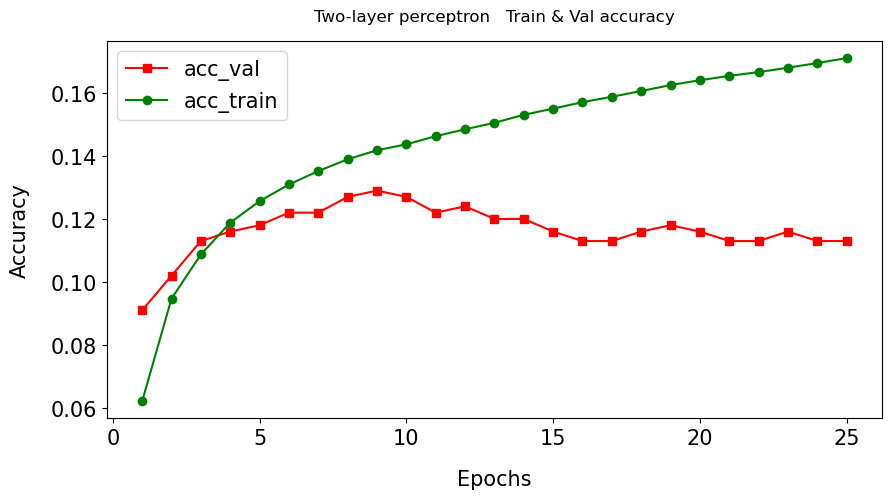

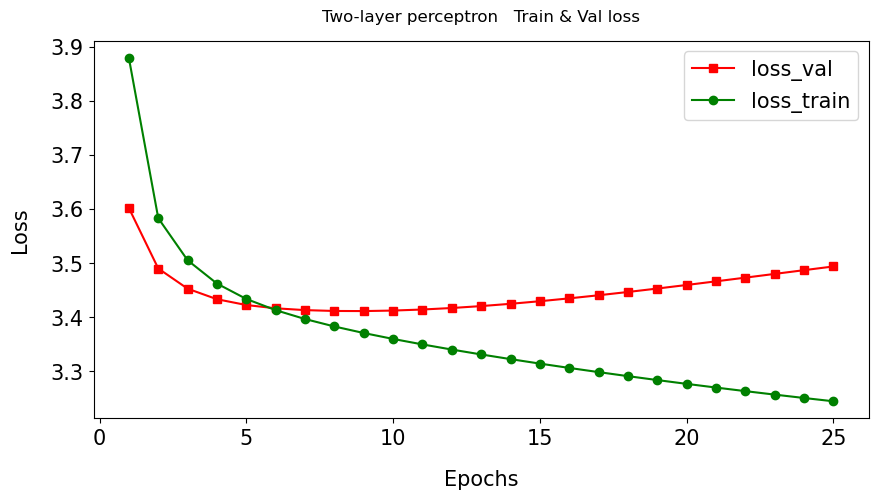

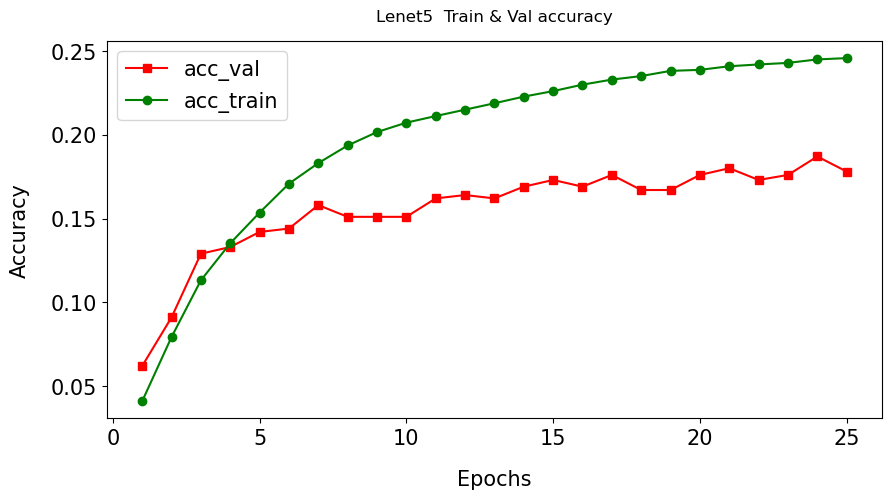

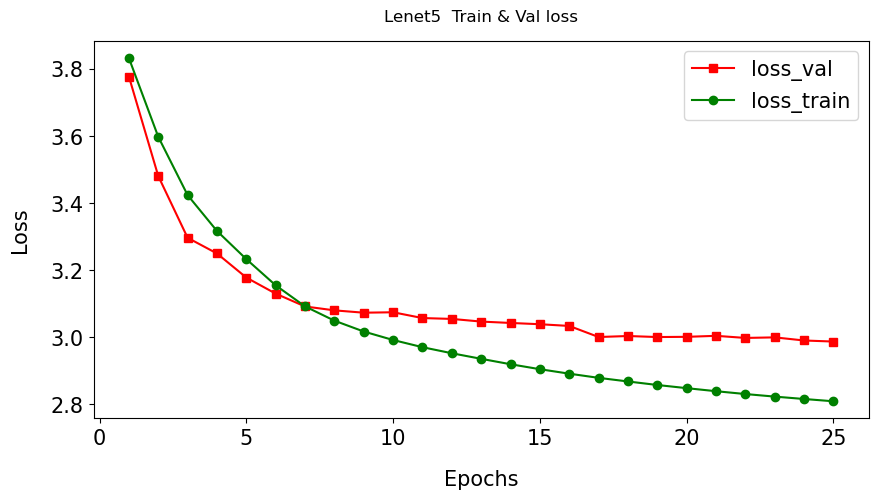

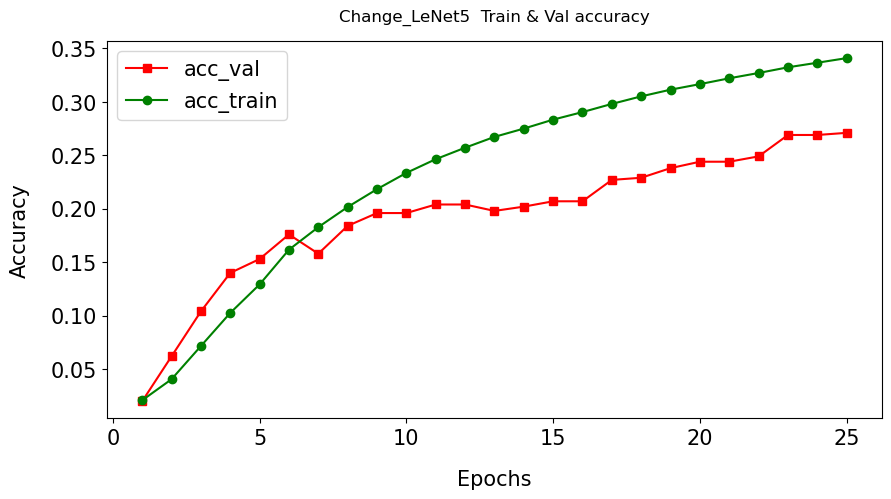

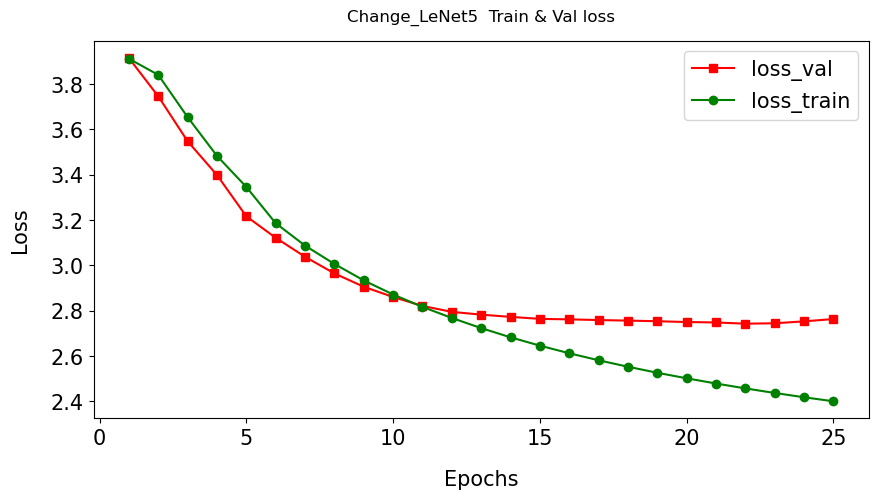

In [132]:
import matplotlib.pyplot as plt
NAME = [model_one_nn,model_two_nn,model_Lenet5,model_change_LeNet]
NAME_str = ["One-layer perceptron","Two-layer perceptron ","Lenet5","Change_LeNet5"]
count = 0
for name in NAME:
    loss_t=[]
    acc_t=[]
    for i in range(len(name.loss_t)):
        if i%(len(name.acc_t)/Epochs) == 61:
            loss_t.append(name.loss_t[i])
            acc_t.append(name.acc_t[i])
    
    #accuracy
    plt.figure(figsize=(10,5),dpi=100,linewidth = 2)
    # 把資料放進來並指定對應的X軸、Y軸的資料，用方形做標記(s-)，並指定線條顏色為紅色，使用label標記線條含意
    plt.plot(range(1,Epochs+1),name.acc_v,'s-',color = 'r', label="acc_val")
    # 把資料放進來並指定對應的X軸、Y軸的資料 用圓形做標記(o-)，並指定線條顏色為綠色、使用label標記線條含意
    plt.plot(range(1,Epochs+1),acc_t,'o-',color = 'g', label="acc_train")
    plt.title(NAME_str[count]+"  Train & Val accuracy",  x=0.5, y=1.03)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    # labelpad代表與圖片的距離
    plt.xlabel("Epochs", fontsize=15, labelpad = 15)
    plt.ylabel("Accuracy", fontsize=15, labelpad = 15)
    plt.legend(loc = "best", fontsize=15)
    plt.show()
    
    #loss
    plt.figure(figsize=(10,5),dpi=100,linewidth = 2)
    plt.plot(range(1,Epochs+1),name.loss_v,'s-',color = 'r', label="loss_val")
    plt.plot(range(1,Epochs+1),loss_t,'o-',color = 'g', label="loss_train")
    plt.title(NAME_str[count]+"  Train & Val loss",  x=0.5, y=1.03)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel("Epochs", fontsize=15, labelpad = 15)
    plt.ylabel("Loss", fontsize=15, labelpad = 15)
    plt.legend(loc = "best", fontsize=15)
    plt.show()
    
    count+=1